ADMM Phantom Study
==================

Introduction
------------
The repository contains a script that demonstrate the effect of different parameter schedules
for plug-and-play alternating direction method of multipliers (ADMM) on its convergence.
To facilitate discussion, I will first briefly describe how I implemented the ADMM algorithm.

Problem statement
-----------------
We are interested in the following optimization problem:
$$\min_x \Vert Ax - b \Vert_2^2 + R(x),$$
which is equivalent to solving
$$\min_{x,z} \Vert Ax - b \Vert_2^2 + R(z) \quad \text{subject to } x = z,$$
where $A$ is the forward operator, $b$ is the observed data, and $R(x)$, whose explicit form might not even exist, denotes the prior term that corresponds to a fixed denoiser of choice.

Before we get started, let's first import the necessary libraries and define our function for computing nRMSE.

In [8]:
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom
from scipy.sparse.linalg import lsqr, LinearOperator
from skimage.restoration import denoise_tv_chambolle

def rmse(a, b):
    return np.linalg.norm(a - b) / np.linalg.norm(b)

As always, we write our own code for the Shepp-Logan phantom.

In [9]:
def get_shepp_logan_phantom(shape=(256, 256)):
    return np.clip(phantom(shape, sl_amps, sl_scales, sl_offsets, sl_angles, float)[::-1, :], 0, 1)

sl_amps = [1, -0.8, -0.2, -0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

sl_scales = [
    [0.6900, 0.920, 0.810],  # white big
    [0.6624, 0.874, 0.780],  # gray big
    [0.1100, 0.310, 0.220],  # right black
    [0.1600, 0.410, 0.280],  # left black
    [0.2100, 0.250, 0.410],  # gray center blob
    [0.0460, 0.046, 0.050],
    [0.0460, 0.046, 0.050],
    [0.0460, 0.046, 0.050],  # left small dot
    [0.0230, 0.023, 0.020],  # mid small dot
    [0.0230, 0.023, 0.020],
]

sl_offsets = [
    [0.0, 0.0, 0],
    [0.0, -0.0184, 0],
    [0.22, 0.0, 0],
    [-0.22, 0.0, 0],
    [0.0, 0.35, -0.15],
    [0.0, 0.1, 0.25],
    [0.0, -0.1, 0.25],
    [-0.08, -0.605, 0],
    [0.0, -0.606, 0],
    [0.06, -0.605, 0],
]

sl_angles = [
    [0, 0, 0],
    [0, 0, 0],
    [-18, 0, 10],
    [18, 0, 10],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0],
]

def phantom(shape, amps, scales, offsets, angles, dtype):
    if len(shape) == 2:
        ndim = 2
        shape = (1, shape[-2], shape[-1])

    elif len(shape) == 3:
        ndim = 3

    else:
        raise ValueError("Incorrect dimension")

    out = np.zeros(shape, dtype=dtype)

    z, y, x = np.mgrid[
        -(shape[-3] // 2): ((shape[-3] + 1) // 2),
        -(shape[-2] // 2): ((shape[-2] + 1) // 2),
        -(shape[-1] // 2): ((shape[-1] + 1) // 2),
    ]

    coords = np.stack(
        (
            x.ravel() / shape[-1] * 2,
            y.ravel() / shape[-2] * 2,
            z.ravel() / shape[-3] * 2,
        )
    )

    for amp, scale, offset, angle in zip(amps, scales, offsets, angles):
        ellipsoid(amp, scale, offset, angle, coords, out)

    if ndim == 2:
        return out[0, :, :]

    else:
        return out

def ellipsoid(amp, scale, offset, angle, coords, out):
    R = rotation_matrix(angle)
    coords = (np.matmul(R, coords) - np.reshape(offset, (3, 1))) / np.reshape(
        scale, (3, 1)
    )
    r2 = np.sum(coords**2, axis=0).reshape(out.shape)
    out[r2 <= 1] += amp

def rotation_matrix(angle):
    cphi = np.cos(np.radians(angle[0]))
    sphi = np.sin(np.radians(angle[0]))
    ctheta = np.cos(np.radians(angle[1]))
    stheta = np.sin(np.radians(angle[1]))
    cpsi = np.cos(np.radians(angle[2]))
    spsi = np.sin(np.radians(angle[2]))
    alpha = [
        [
            cpsi * cphi - ctheta * sphi * spsi,
            cpsi * sphi + ctheta * cphi * spsi,
            spsi * stheta,
        ],
        [
            -spsi * cphi - ctheta * sphi * cpsi,
            -spsi * sphi + ctheta * cphi * cpsi,
            cpsi * stheta,
        ],
        [
            stheta * sphi, -stheta * cphi, ctheta
        ],
    ]
    return np.array(alpha)

Then, we define our forward and adjoint operators. Here, for the sake of simplicity, we will just take the forward operator to be that of undersampling and the corresponding adjoint operator is then the operator that corresponds to zero-filling.

In [10]:
def A_forward_vert(x, factor=2):
    return x[::factor, :]

def A_forward_horiz(x, factor=2):
    return x[:, ::factor]

def A_adj_vert(y, factor=2, output_shape=None):
    if output_shape is None:
        raise ValueError("output_shape must be provided.")
    x = np.zeros(output_shape)
    x[::factor, :] = y
    return x

def A_adj_horiz(y, factor=2, output_shape=None):
    if output_shape is None:
        raise ValueError("output_shape must be provided.")
    x = np.zeros(output_shape)
    x[:, ::factor] = y
    return x

We solve this problem using the plug-and-play ADMM algorithm, which consists of the following iterative steps:

1. **x-update**: Updating $x$ while keeping $z$ fixed:
$$x^{(k+1)} = \underset{x}{\arg\min} \left\{\Vert Ax - b \Vert_2^2 + \frac{\rho^{(k+1)}}{2} \Vert x - (z^{(k)} - u^{(k)}) \Vert_2^2\right\}.$$

2. **z-update**: Updating $z$ while keeping $x$ fixed:
$$z^{(k+1)} = \underset{z}{\arg\min} \left\{R(z) + \frac{\rho^{(k+1)}}{2} \Vert z - (x^{(k+1)} + u^{(k)}) \Vert_2^2\right\},$$
which, in our case, is replaced by a plug-and-play denoiser $\mathcal{D}$:
$$z^{(k+1)} = \mathcal{D}(x^{(k+1)} + u^{(k)}).$$
Here, we assume that the denoiser $\mathcal{D}$ is a fixed denoiser, in a sense that the denoiser does not have a tunable knob for the amount of denoising it applies.
But we can introduce a relaxation parameter $\alpha$ that can be used to control the amount of denoising applied to the image:
$$\quad z^{(k+1)} = \alpha^{(k+1)} \cdot \mathcal{D}(x^{(k+1)} + u^{(k)}) + (1 - \alpha^{(k+1)}) \cdot (x^{(k+1)} + u^{(k)}).$$

3. **u-update**: Updating the dual variable $u$:
    $$u^{(k+1)} = u^{(k)} + (x^{(k+1)} - z^{(k+1)})$$

The plug-and-play ADMM algorithm is implemented below:

In [11]:
def run(tv_weight, rho0, gamma, alpha_start, alpha_end, show_recon_plot=False, show_rmse_plot=False, show_rho_alpha_plot=True, cosine=False):
    # configs
    high_res_shape = (512, 512)  # simulated phantom fov
    R = 4  # undersampling factor
    max_iter_admm = 20  # max number of ADMM iterations
    max_iter_lsqr = 20  # max number of LSQR iterations
    tol_lsqr = 1e-5  # tolerance for LSQR
    show_recon_plot = show_recon_plot
    show_rmse_plot = show_rmse_plot
    show_rho_alpha_plot = show_rho_alpha_plot

    # rho and alpha schedule
    rho0 = rho0  # initial rho
    gamma = gamma  # rho scaling factor
    alpha_start = alpha_start  # initial alpha
    alpha_end = alpha_end  # final alpha
    rho_schedule = lambda k: get_rho_schedule(k, rho0=rho0, gamma=gamma)
    if cosine:
        alpha_schedule = lambda k: get_alpha_schedule_cosine(k, max_iter_admm, alpha_start=alpha_start, alpha_end=alpha_end)
    else:
        alpha_schedule = lambda k: get_alpha_schedule(k, max_iter_admm, alpha_start=alpha_start, alpha_end=alpha_end)

    # phantom (hr)
    phantom_hr = get_shepp_logan_phantom(high_res_shape)

    # phantom (lr)
    y1 = A_forward_vert(phantom_hr, factor=R)
    y2 = A_forward_horiz(phantom_hr, factor=R)

    # initial guesses
    x = np.zeros(high_res_shape)
    z = np.zeros(high_res_shape)
    u = np.zeros(high_res_shape)

    # TV denoising weight
    tv_weight = tv_weight

    # print
    suffix = f'tv_{tv_weight}_r_{rho0}_g_{gamma}_a_{alpha_start}_{alpha_end}'
    # print(f'Running with tv_weight={tv_weight}, rho0={rho0}, gamma={gamma}, alpha_start={alpha_start}, alpha_end={alpha_end}')

    # forward and adjoint operators
    def build_A_operator(rho, factor, im_shape):
        N = im_shape[0] * im_shape[1]
        N1 = (im_shape[0] // factor) * im_shape[1]
        N2 = im_shape[0] * (im_shape[1] // factor)
        n_rows = N1 + N2 + N
        n_cols = N
        def matvec(x_vec):
            x_img = x_vec.reshape(im_shape)
            r1 = A_forward_vert(x_img, factor=factor)
            r2 = A_forward_horiz(x_img, factor=factor)
            r3 = np.sqrt(rho) * x_img
            return np.concatenate([r1.ravel(), r2.ravel(), r3.ravel()])
        def rmatvec(y_vec):
            y1 = y_vec[0:N1].reshape((im_shape[0] // factor, im_shape[1]))
            y2 = y_vec[N1:N1+N2].reshape((im_shape[0], im_shape[1] // factor))
            y3 = y_vec[N1+N2:].reshape(im_shape)
            a1 = A_adj_vert(y1, factor=factor, output_shape=im_shape)
            a2 = A_adj_horiz(y2, factor=factor, output_shape=im_shape)
            a3 = np.sqrt(rho) * y3
            return (a1 + a2 + a3).ravel()
        return LinearOperator((n_rows, n_cols), matvec=matvec, rmatvec=rmatvec, dtype=np.float64)

    # ADMM
    history = {'rmse_x': [], 'rmse_z': [], 'rmse_all': []}

    for k in range(max_iter_admm):
        # rho and alpha
        current_rho = rho_schedule(k)
        current_alpha = alpha_schedule(k)

        # lhs
        A_op = build_A_operator(current_rho, factor=R, im_shape=high_res_shape)

        # rhs
        b_rhs = np.concatenate([
            y1.ravel(),
            y2.ravel(),
            (np.sqrt(current_rho) * (z - u)).ravel()
        ])

        # step 1
        sol = lsqr(A_op, b_rhs, iter_lim=max_iter_lsqr, atol=tol_lsqr, btol=tol_lsqr)
        x_vec = sol[0]
        x = x_vec.reshape(high_res_shape)
        # callback
        current_rmse_x = rmse(x, phantom_hr)
        history['rmse_x'].append(current_rmse_x)
        history['rmse_all'].append(current_rmse_x)

        # step 2
        x_plus_u = x + u
        denoised = denoise_tv_chambolle(x_plus_u, weight=tv_weight)
        z = current_alpha * denoised + (1 - current_alpha) * x_plus_u
        # callback
        current_rmse_z = rmse(z, phantom_hr)
        history['rmse_z'].append(current_rmse_z)
        history['rmse_all'].append(current_rmse_z)

        # step 3
        u = u + (x - z)

    print(f'Final nRMSE (x): {current_rmse_x * 100:.2f}%')
    # print(f'Final nRMSE (z): {current_rmse_z * 100:.2f}%')

    # plot recon
    fig, axes = plt.subplots(2, 3, figsize=(6, 4), layout='constrained')
    for ax in axes.flat:
        ax.axis('off')
    axes[0, 0].imshow(phantom_hr, cmap='gray', vmin=0, vmax=1, interpolation='nearest')
    axes[0, 0].set_title('High resolution')
    axes[0, 1].imshow(zoom(y1, (R, 1), order=0), cmap='gray', vmin=0, vmax=1, interpolation='nearest')
    axes[0, 1].set_title('Low resolution (vertical)')
    axes[0, 2].imshow(x, cmap='gray', vmin=0, vmax=1, interpolation='nearest')
    axes[0, 2].set_title('Recon (x)')
    axes[1, 0].imshow(np.zeros_like(phantom_hr), cmap='gray', vmin=0, vmax=1, interpolation='nearest')
    axes[1, 1].imshow(np.abs(phantom_hr - zoom(y1, (R, 1), order=0)), cmap='gray', vmin=0, vmax=1, interpolation='nearest')
    axes[1, 1].set_title(f'nRMSE: {rmse(zoom(y1, (R, 1), order=0), phantom_hr) * 100:.2f}%')
    axes[1, 2].imshow(np.abs(phantom_hr - x), cmap='gray', vmin=0, vmax=1, interpolation='nearest')
    axes[1, 2].set_title(f'nRMSE: {rmse(x, phantom_hr) * 100:.2f}%')
    fig.savefig(f'phantom_recon_{suffix}.png', dpi=300)
    if show_recon_plot:
        plt.show()
    plt.close('all')

    # plot nrmse
    fig, axes = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
    axes.plot(history['rmse_x'], label='nRMSE after ADMM (x)', marker='o', color='C2')
    axes.plot(history['rmse_z'], label='nRMSE after TV denoising (z)', marker='s', color='C3')
    axes.set_xlabel('ADMM Iteration')
    axes.set_ylabel('nRMSE')
    axes.set_ylim(0.1, 0.9)
    axes.set_xticks(range(0, len(history['rmse_x'])))
    # axes.set_title('nRMSE vs ADMM  Iteration')
    axes.legend()
    axes.grid(True)
    fig.savefig(f'phantom_rmse_{suffix}.png', dpi=300)
    if show_rmse_plot:
        plt.show()
    plt.close('all')

    # plot rho and alpha
    fig, axes = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')
    axes.plot([rho_schedule(k) for k in range(max_iter_admm)], label='rho', marker='o', color='C0')
    axes.set_ylabel('rho', color='C0')
    axes.set_ylim(-0.05, 1.05)
    axes.tick_params(axis='y', labelcolor='C0')
    axes_other = axes.twinx()
    axes_other.plot([alpha_schedule(k) for k in range(max_iter_admm)], label='alpha', marker='s', color='C1')
    axes_other.set_ylabel('alpha', color='C1')
    axes_other.set_ylim(-0.05, 1.05)
    axes_other.tick_params(axis='y', labelcolor='C1')
    axes.set_xlabel('ADMM Iteration')
    axes.set_xticks(range(0, max_iter_admm))
    # axes.set_title('rho and alpha vs ADMM Iteration')
    axes.grid(True)
    fig.savefig(f'phantom_rho_alpha_{suffix}.png', dpi=300)
    if show_rho_alpha_plot:
        plt.show()
    plt.close('all')
    return current_rmse_x

Method
------
Now, I want to explore the effect of a $\rho$ schedule and a $\alpha$ schedule on the convergence of the algorithm. Especially, I am interested in the case where the denoiser has *fixed strength*, i.e., does not have a tunable knob for the amount of denoising it applies to the image and where the denoiser is *somewhat biased* and *somewhat overly smoothing*. This kind of assumption is common when a deep learning based denoiser is pre-learned and used here as a plug-and-play denoiser. Usually a deep learning based denoiser does not have such a tunable knob and it can sometimes be biased and overly smoothing.

One might argue that an increasing $\rho$ schedule is a good idea, because a larger $\rho$ draws the primal variables $x$ and $z$ closer to each other which eventually leads to a fixed-point convergence. However, I argue (although I didn't believe this is the case either at the very beginning) that a decreasing $\rho$ schedule in our specific case is a better idea. The key observation is that our denoiser of interest is somewhat too strong. A strong denoiser along with a larger $\rho$ pulls $x$ towards $z$ at the beginning, but as the algorithm approaches the true underlying solution, we might want the denoiser to be less dominant and depend more on the data consistency term. This can be done in two ways: (1) by adopting a non-increasing $\alpha$ schedule, or (2) by adopting a non-increasing $\rho$ schedule.

First, we explore a non-increasing $\alpha$ schedule. Notice that as $\alpha \to 0$, less weight is given to the denoiser when updating $z$. Specifically, given initial value $\alpha_0$, final value $\alpha_1$, and maximum number of ADMM iterations $K$, a cosine annealing schedule is used (but other non-increasing schedules should also work equally well, e.g., a linear schedule):
$$\alpha^{(k)} = \frac{1}{2} \cdot (\alpha_0 + \alpha_1) + \frac{1}{2} \cdot (\alpha_0 - \alpha_1) \cdot \cos(\pi \cdot k/K), \quad \alpha_0, \alpha_1 \in [0,1]$$

In [12]:
def get_alpha_schedule(k, max_iter_admm, alpha_start=1.0, alpha_end=1.0):
    return alpha_start + (alpha_end - alpha_start) * (k / max_iter_admm)

def get_alpha_schedule_cosine(k, max_iter_admm, alpha_start=1.0, alpha_end=1.0):
    alpha = 0.5 * (alpha_start + alpha_end) + 0.5 * (alpha_start - alpha_end) * np.cos(np.pi * k / max_iter_admm)
    return alpha

Then, we explore a non-increasing $\rho$ schedule. Specifically, given initial value $\rho_0$ and scaling factor $\gamma$, a decreasing exponential schedule is used:
$$\rho^{(k)} = \rho_0 \cdot \gamma^k, \quad \gamma \in (0,1).$$

In [13]:
def get_rho_schedule(k, rho0=1.0, gamma=1.0):
    return rho0 * (gamma ** k)

Results
-------
For $\alpha$ schedule, we fix $\rho = 1$, $\gamma = 1$ (i.e., a fixed $\rho$ schedule), $\alpha_0 = 1$, and try $\alpha_1 \in \{1.0, 0.8, 0.6, 0.4, 0.2, 0.0\}$ with a cosine annealing schedule.

alpha_end = 1.0
Final nRMSE (x): 26.39%


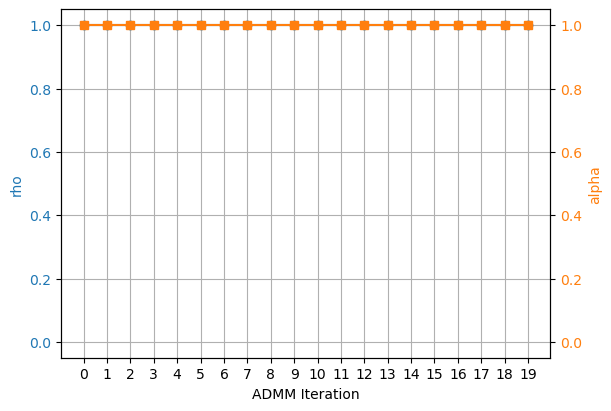

alpha_end = 0.8
Final nRMSE (x): 24.56%


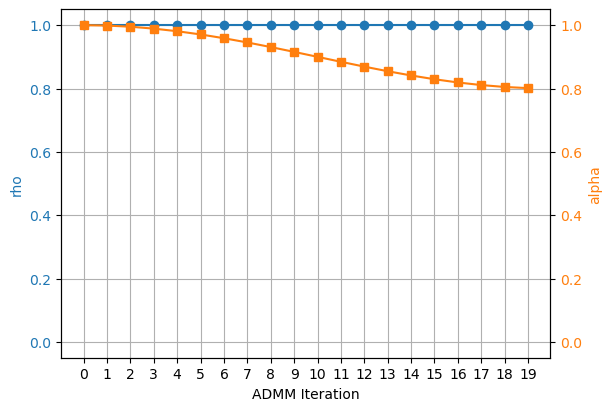

alpha_end = 0.6
Final nRMSE (x): 22.13%


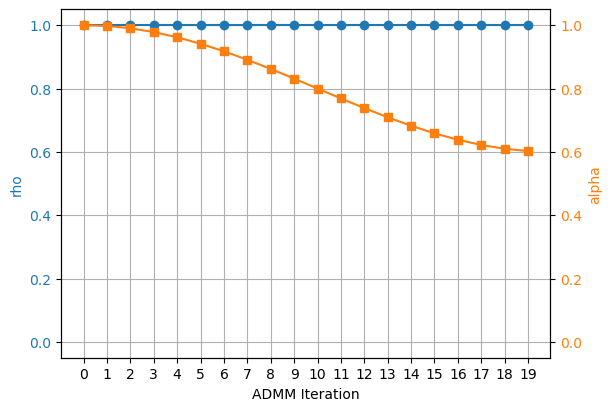

alpha_end = 0.4
Final nRMSE (x): 21.73%


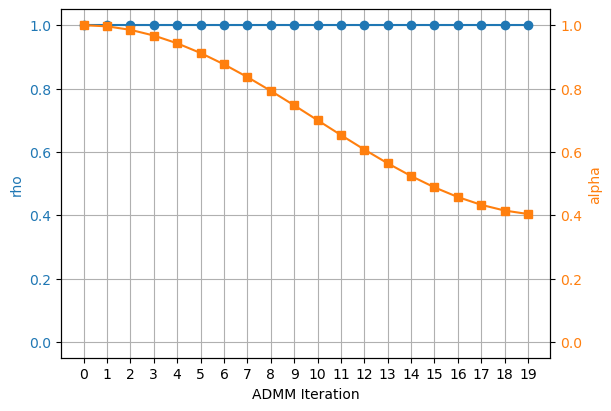

alpha_end = 0.2
Final nRMSE (x): 20.26%


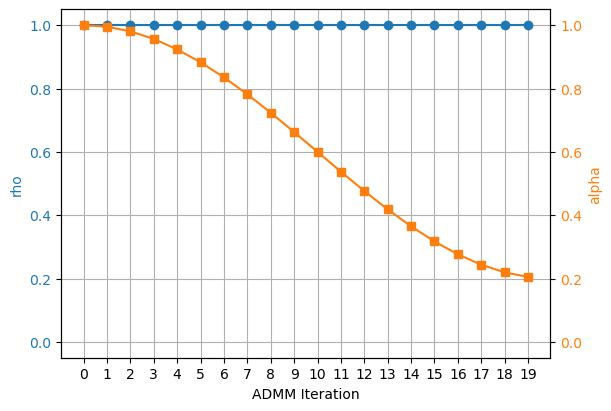

alpha_end = 0.0
Final nRMSE (x): 20.48%


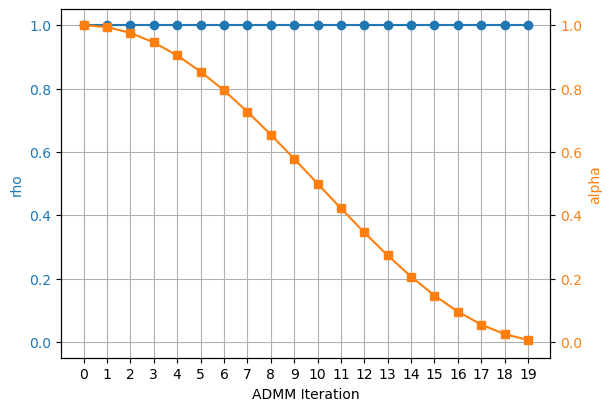

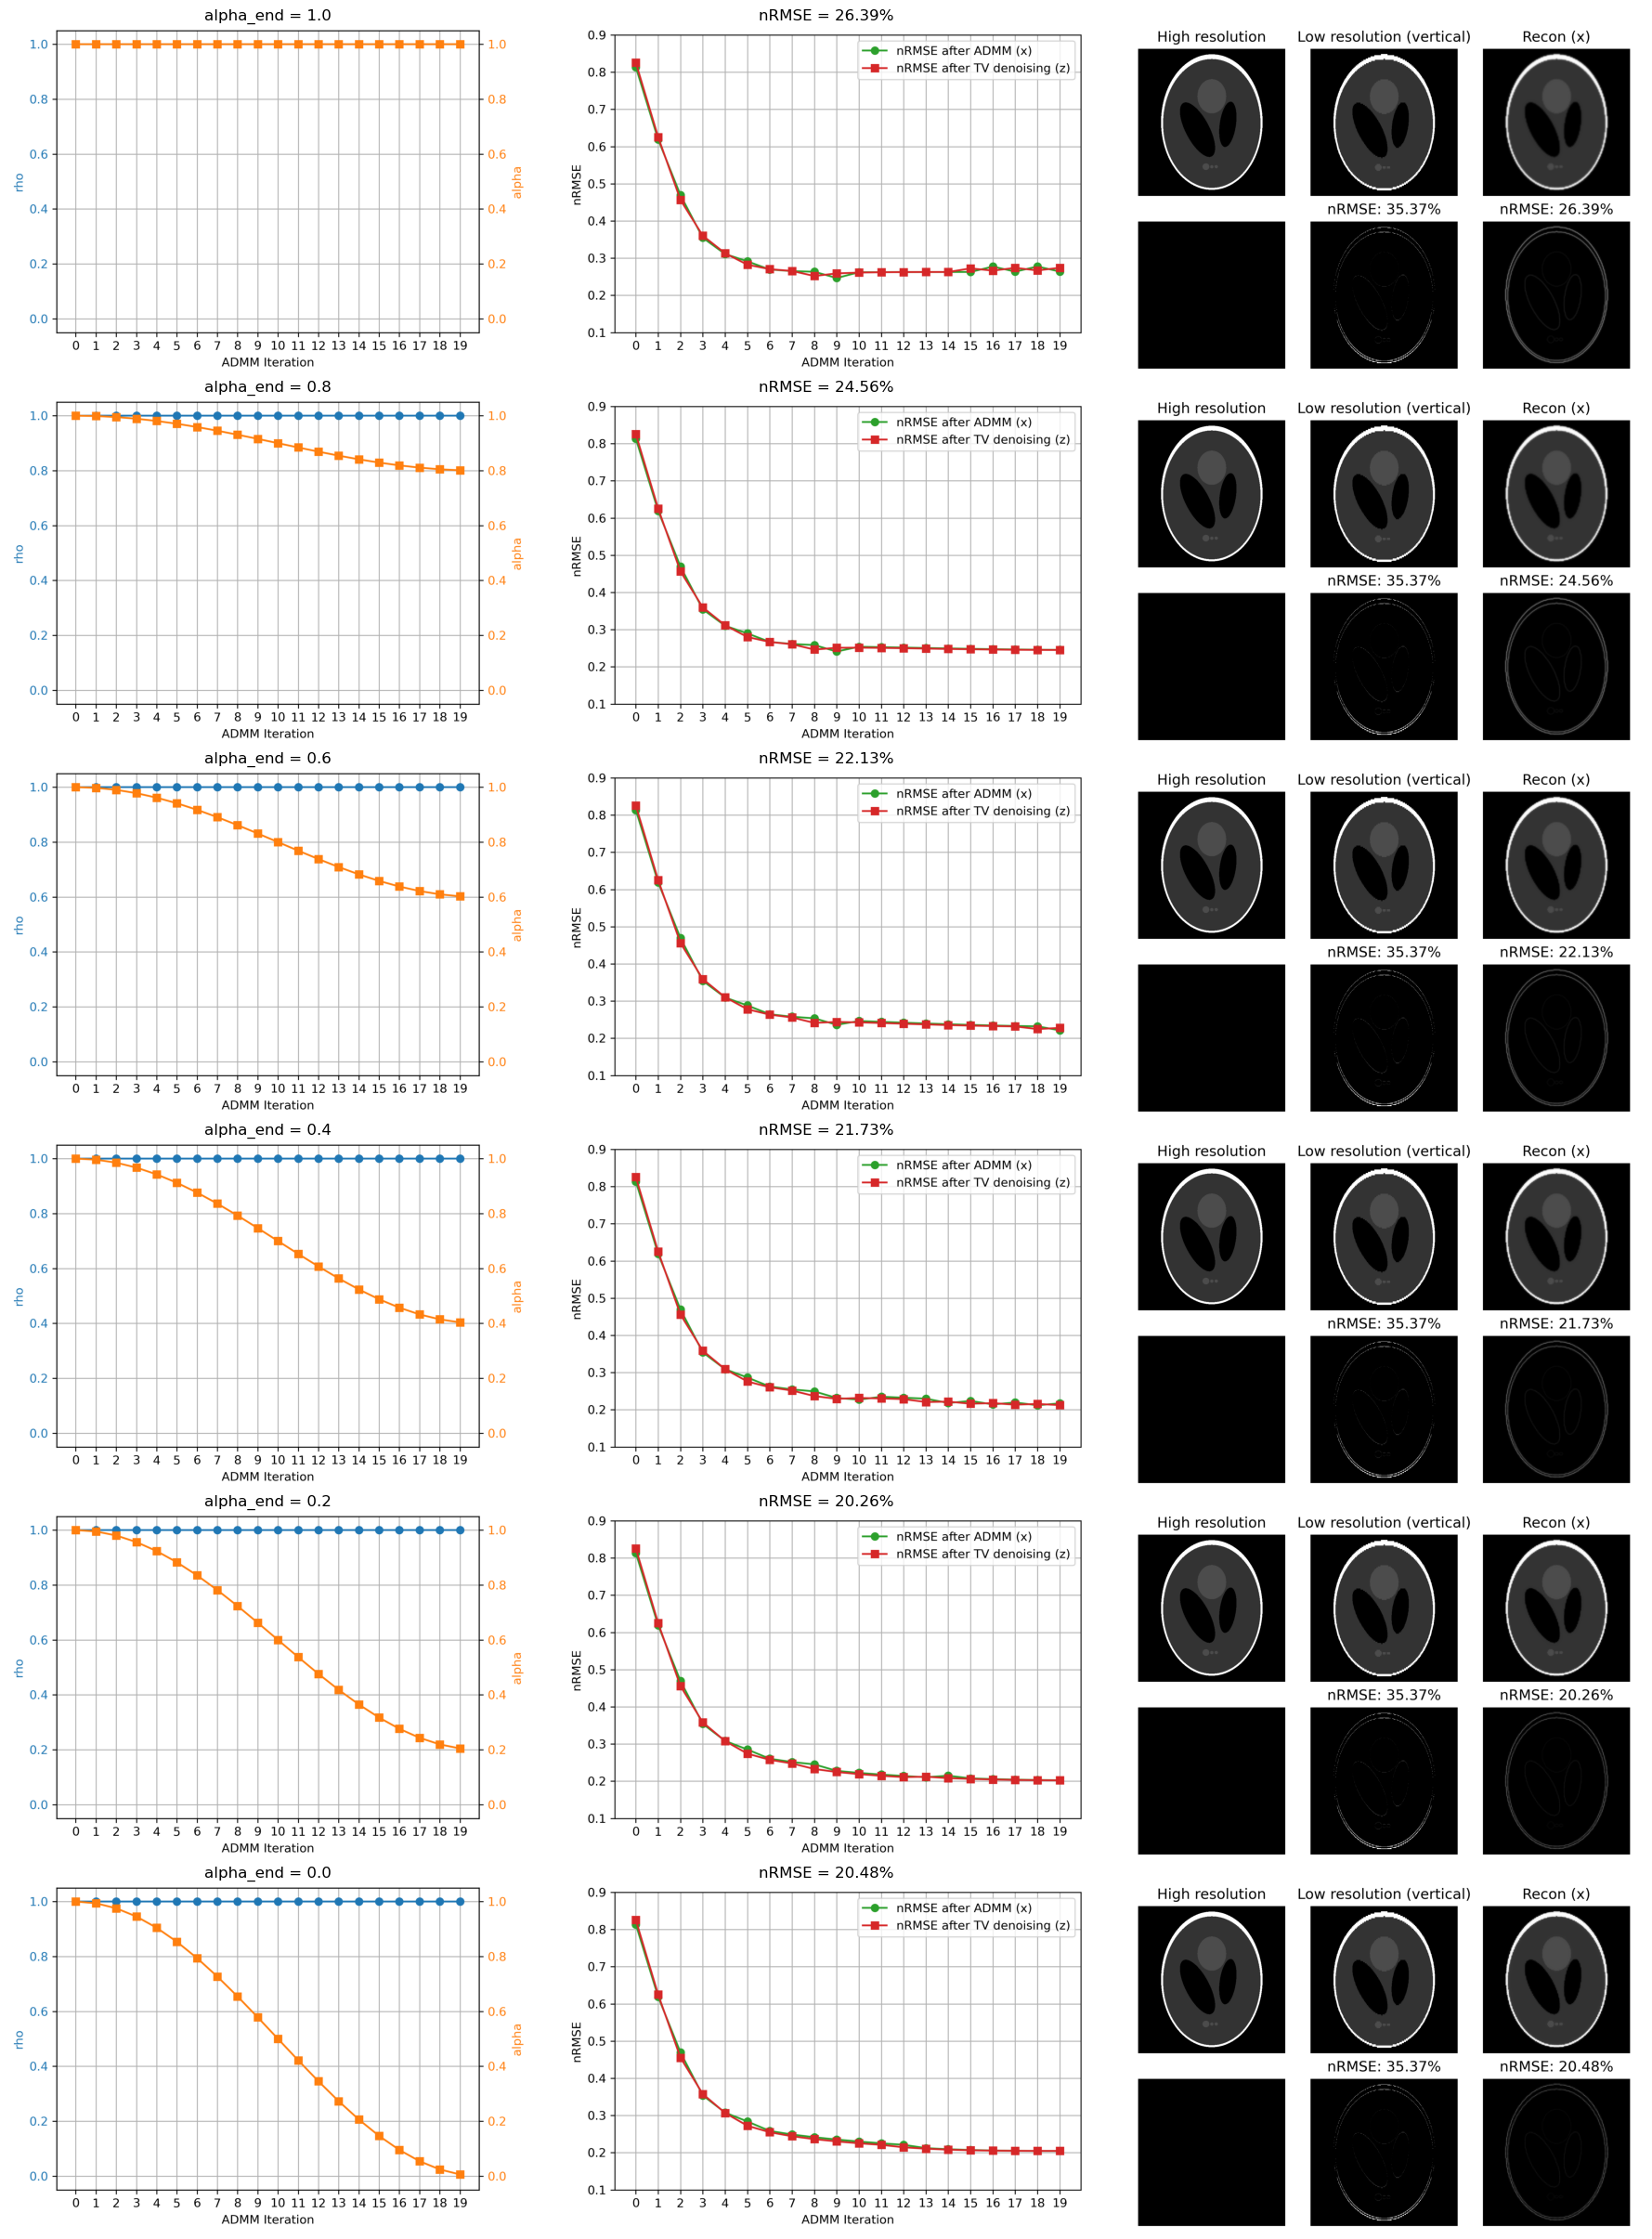

In [16]:
tv_weight_lst = [1.0]
rho0_lst = [1.0]
gamma_lst = [1.0]
alpha_start_lst = [1.0]
alpha_end_lst = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
cosine = True
lst = list(product(tv_weight_lst, rho0_lst, gamma_lst, alpha_start_lst, alpha_end_lst))
result_lst = []
for tv_weight, rho0, gamma, alpha_start, alpha_end in lst:
    print(f'alpha_end = {alpha_end}')
    result = run(tv_weight, rho0, gamma, alpha_start, alpha_end, cosine=cosine)
    result_lst.append(result)

fig, axes = plt.subplots(6, 3, figsize=(18, 24), layout='constrained')
for i, (tv_weight, rho0, gamma, alpha_start, alpha_end) in enumerate(lst):
    suffix = f'tv_{tv_weight}_r_{rho0}_g_{gamma}_a_{alpha_start}_{alpha_end}'
    axes[i, 0].imshow(plt.imread(f'phantom_rho_alpha_{suffix}.png'))
    axes[i, 0].set_title(f'alpha_end = {alpha_end}')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(plt.imread(f'phantom_rmse_{suffix}.png'))
    axes[i, 1].set_title(f'nRMSE = {result_lst[i] * 100:.2f}%')
    axes[i, 1].axis('off')
    axes[i, 2].imshow(plt.imread(f'phantom_recon_{suffix}.png'))
    # axes[i, 2].set_title(f'nRMSE = {result_lst[i] * 100:.2f}%')
    axes[i, 2].axis('off')
fig.savefig('phantom_alpha_all', dpi=300)
plt.show()

For $\rho$ schedule, we fix a cosine annealing schedule for $\alpha$ with $\alpha_0 = 1$, $\alpha_1 = 0$, and try $\gamma \in \{1.0, 0.9, 0.8, 0.7, 0.6, 0.5\}$ with $\rho_0 = 1$.

gamma = 1.0
Final nRMSE (x): 20.48%


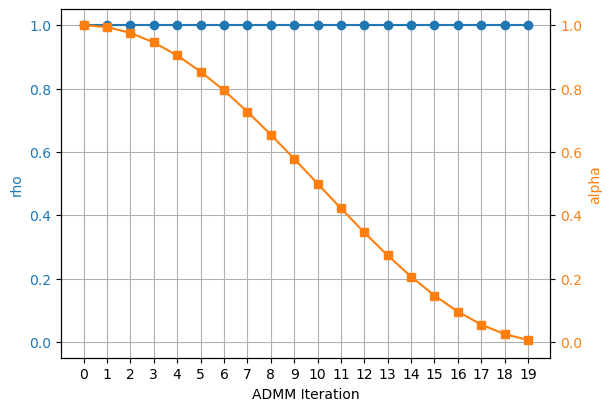

gamma = 0.9
Final nRMSE (x): 20.09%


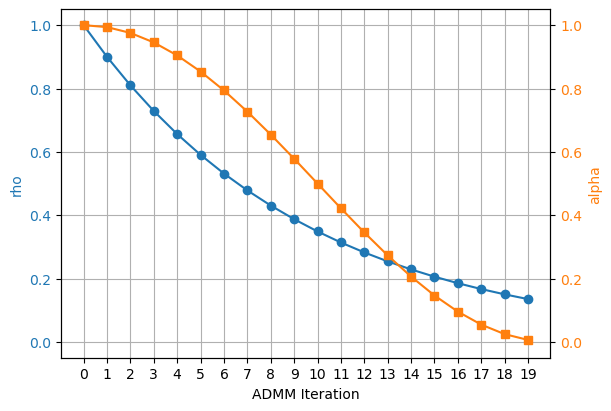

gamma = 0.8
Final nRMSE (x): 19.58%


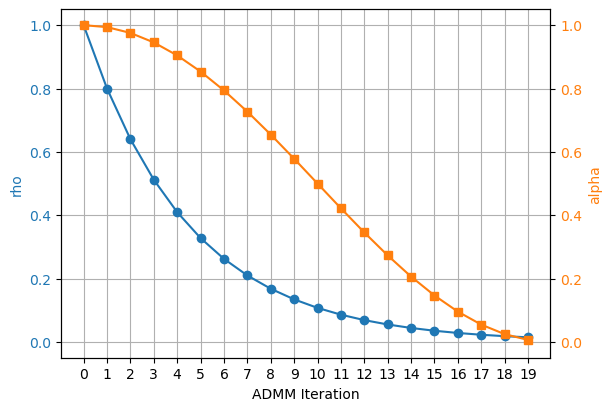

gamma = 0.7
Final nRMSE (x): 19.34%


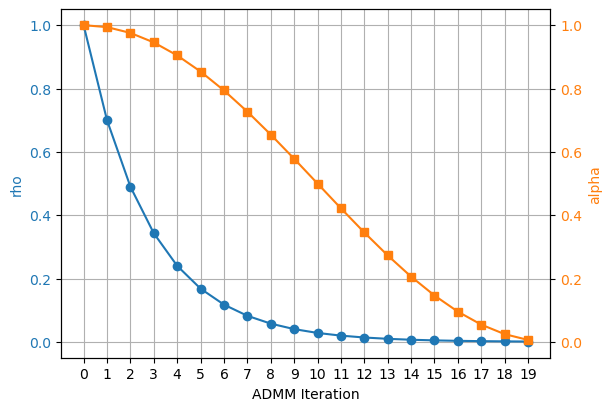

gamma = 0.6


In [ ]:
tv_weight_lst = [1.0]
rho0_lst = [1.0]
gamma_lst = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
alpha_start_lst = [1.0]
alpha_end_lst = [0.0]
cosine = True
lst = list(product(tv_weight_lst, rho0_lst, gamma_lst, alpha_start_lst, alpha_end_lst))
result_lst = []
for tv_weight, rho0, gamma, alpha_start, alpha_end in lst:
    print(f'gamma = {gamma}')
    result = run(tv_weight, rho0, gamma, alpha_start, alpha_end, cosine=cosine)
    result_lst.append(result)

fig, axes = plt.subplots(6, 3, figsize=(18, 24), layout='constrained')
for i, (tv_weight, rho0, gamma, alpha_start, alpha_end) in enumerate(lst):
    suffix = f'tv_{tv_weight}_r_{rho0}_g_{gamma}_a_{alpha_start}_{alpha_end}'
    axes[i, 0].imshow(plt.imread(f'phantom_rho_alpha_{suffix}.png'))
    axes[i, 0].set_title(f'gamma = {gamma}')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(plt.imread(f'phantom_rmse_{suffix}.png'))
    axes[i, 1].set_title(f'nRMSE = {result_lst[i] * 100:.2f}%')
    axes[i, 1].axis('off')
    axes[i, 2].imshow(plt.imread(f'phantom_recon_{suffix}.png'))
    # axes[i, 2].set_title(f'nRMSE = {result_lst[i] * 100:.2f}%')
    axes[i, 2].axis('off')
fig.savefig('phantom_rho_all', dpi=300)
plt.show()

Conclusion
----------
Both schedules work.